# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import pyarrow
import itertools

import librosa
from scipy.signal import stft
from scipy import signal
from scipy.fft import rfft
import pywt

from tqdm import tqdm
import os
import gc
import time

# Functions

In [2]:
def read_and_preprocess(path='', encoding='utf_16'):

    # csv.Sniffer().sniff() method is used to automatically detect the delimiter character of the CSV file
    # Open the CSV file
    with open(path, 'r', encoding=encoding) as csvfile:
        # Create a CSV reader object
        dialect = csv.Sniffer().sniff(csvfile.read(1024))
        # Get the delimiter character
        delimiter = dialect.delimiter
    print(f'Reading {path}')
        
    data_ = pd.read_csv(path, sep=delimiter, encoding=encoding, low_memory=False)
    data_.rename({"VIBRATION_V_PA/RED/QA Time":"Time", "VIBRATION_V_PA/RED/QA ValueY":"Value"}, axis='columns', inplace=True)
    data_.Value = data_.Value.apply(lambda x : float(x.replace(',','.')))
    data_.Time = pd.to_datetime(data_.Time, format="%d/%m/%Y %H:%M:%S")
    data_.set_index("Time", drop=True, inplace=True)
    
    # Change the duplicated index values from two times 2022-06-01 00:00:01 to 00:00:01.0 and 00:00:01.5
    counts = data_.groupby(data_.index).cumcount()
    counts = np.where((counts > 0), 5, counts)

    new_index = data_.index.astype(str) + '_' + counts.astype(str)
    data_.index = pd.to_datetime(new_index, format='%Y-%m-%d %H:%M:%S_%f')
    start_date = data_.index.min()
    end_date = data_.index.max()
    date_range = pd.date_range(start=start_date, end=end_date, freq='0.5S')
    data_ = data_.reindex(date_range)
    data_['Real'] = False
    data_['Real'] = np.where((data_.Value > 0) , True, data_.Real)
    data_.replace(0, np.NaN, inplace=True)
    median = data_.Value.median()
    std = data_.Value.std()
    data_.Value = data_.Value.apply(lambda l: l if not np.isnan(l) else np.random.normal(median, std/3))
    data_.index.name = 'Time'
    
    return data_

def concat_data(datas=[]):
    concat = pd.concat(datas)
    concat.fillna(concat.Value.median(), inplace=True)
    concat = concat.sort_index().reset_index()
    concat = concat.drop_duplicates(subset='Time')
    concat.set_index('Time', inplace=True)
    
    start_date = concat.index.min()
    end_date = concat.index.max()
    date_range = pd.date_range(start=start_date, end=end_date, freq='0.5S')
    concat = concat.reindex(date_range)
    concat.replace(0, np.NaN, inplace=True)
    median = concat.Value.median()
    std = concat.Value.std()
    
    concat.Value = concat.Value.apply(lambda l: l if not np.isnan(l) else np.random.normal(median, std/3))
    concat.Real.fillna(False, inplace=True)
    concat = concat.sort_index()
    
    print('Concatenation done')
    return concat

def replace_outliers(data, factor=1.5):
    # Using Interquartile range (IQR)
    
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1

    median = data.Value.median()
    std = data.Value.std()
    maxx = data.Value.max()
    # The lower and upper bounds beyond which a value is considered an outlier
    lower_bound = q1 - (factor * iqr)
    upper_bound = q3 + (factor * iqr)
    print(f'Outlier bound [{lower_bound},{upper_bound}]')

    # Replace any values outside the bounds with NaN
    data.Real = np.where((data.Value < lower_bound) | (data.Value > upper_bound), False, data.Real)
    data.Value = np.where((data.Value < lower_bound) | (data.Value > upper_bound), np.random.normal(median, std/3), data.Value)
    data = data.sort_index()
    print('outliers done')
    return data

def generate_spectr_coeff(data, kind="mfcc", period=60):
    coeff = []
    split = []
    date = []
    
    # Params
    sample_rate = 2
    frame_size = 256
    hop = 32
    n_coeff = 20
    lifter = 0
    n_mels = 20
    dct = 2
    win_length=32
    wind = 'tukey'
    
    step = period*120
    for i in range(0,len(data),step):
        split.append(data.Value.iloc[i:i+step].tolist())
        date.append(f"{data.index[i].month}_{data.index[i].day} {data.index[i].hour}-{data.index[i].minute}")
            
    ############        
    ### MFCC ###        
    if kind == "mfcc":
        for j in tqdm(range(len(split)-1)):
            
            coef = librosa.feature.mfcc(y=np.array(split[j]), sr=sample_rate, lifter=lifter, n_fft=frame_size, hop_length=hop, win_length=win_length, n_mfcc=n_coeff, n_mels=n_mels, dct_type=dct, window=wind)
            # Compute delta coefficients
            deltas = librosa.feature.delta(coef)
            deltasdeltas = librosa.feature.delta(deltas)

            # Concatenate the MFCC and delta coefficients
            features = np.concatenate((coef, deltas, deltasdeltas), axis=0)
            coeff.append(features)
            # del features
    
    ############        
    ### STFT ###    
    elif kind == "stft":
        for j in tqdm(range(len(split))):
            signal = split[j]
            window = wind
            #The length of each segment of the signal, measured in samples.
            nperseg = sample_rate*50
            noverlap = nperseg//2

            # Compute STFT
            f, t, Zxx = stft(signal, fs=sample_rate, window=window, nperseg=nperseg, noverlap=noverlap)

            # Convert magnitude spectrogram to dB scale
            # np.finfo(float).eps to avoid taking log(0)
            coeff.append(20 * np.log10(np.abs(Zxx + np.finfo(float).eps)))
            del f, t, Zxx
    
    ###########        
    ### CWT ###
    elif kind == "cwt":
        for j in tqdm(range(len(split))):
            signal = split[j]
            wavelet = "morl"
            coef, freqs = pywt.cwt(signal, np.arange(1, 128), wavelet)
            
    elif kind == "fft":
        for j in tqdm(range(len(split))):
            signal = split[j]
            fft_sig = rfft(signal, axis=-1, norm='ortho', overwrite_x=False)
            coeff.append(np.abs(fft_sig[1:]))
            
    del split
    print(f'Coefficient computed {np.max(coeff[0])}, {np.min(coeff[0])}')
    return coeff, date

def generate_spectr(coeff, date, folder_name="", kind="mfcc"):
    directory = folder_name
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f"Saving images in {directory}")
    if kind == "mfcc":
        for i,co in enumerate(tqdm(coeff)):
            fig, ax = plt.subplots(figsize=(5,5))
            librosa.display.specshow(co, cmap='inferno', vmin=-10, ax=ax)
            fig.savefig(f'{directory}/{date[i]}.png', bbox_inches='tight', pad_inches=0)
            plt.close(fig)
            fig, ax = None, None
    elif kind == "stft":
        for i in tqdm(range(len(coeff))):
            img = plt.pcolormesh(coeff[i], cmap='inferno')
            plt.axis('off')
            plt.savefig(f'{directory}/{date[i]}.png')
            plt.close()
            del img
    elif kind == "fft":
        for i,co in enumerate(tqdm(coeff)):
            fig, ax = plt.subplots(figsize=(3,3))
            ax.plot(co)
            fig.savefig(f'{directory}/{date[i]}.png', bbox_inches='tight', pad_inches=0)
            plt.close(fig)
            fig, ax = None, None
    return gc.collect()

def generate_data(data_folder:str='', start:str='', end:str='', ouput_name='Images', kind="mfcc", folders='all'):
    
    # For saving all data folders pass data_folder="FolderName"
    if folders == 'all':
        month = os.listdir(data_folder)
        for m in month:
            records = os.listdir(f'{data_folder}/{m}')
            data_m = []
            for r in records:
                data_m.append(read_and_preprocess(f'{data_folder}/{m}/{r}'))
            record_data = concat_data(data_m)
            data_m = None
            records = None
            record_data = replace_outliers(record_data)
            coeff, date = generate_spectr_coeff(record_data, kind=kind)
            record_data = None
            generate_spectr(coeff, date, kind=kind, folder_name=f'{ouput_name}_{kind}/{m}')
            coeff, date = None, None
            del coeff, date, record_data, data_m, records
            print(gc.collect())
    
    # For saving one month data pass data_folder="FolderName/Vibration_month"
    elif folders == 'one':
        records = os.listdir(f'{data_folder}')
        data_m = []
        for r in records:
            data_m.append(read_and_preprocess(f'{data_folder}/{r}'))
        record_data = concat_data(data_m)
        data_m = None
        records = None
        record_data = replace_outliers(record_data)
        if start and end:
            record_data = record_data.loc[start:end]
        coeff, date = generate_spectr_coeff(record_data, kind=kind)
        record_data = None
        generate_spectr(coeff,  date, folder_name=f'{ouput_name}_{kind}/{date[0]} to {date[-1]}', kind=kind)
        coeff, date = None, None
        del coeff, date, record_data, data_m, records
        print(gc.collect())
    
    # For reading and returning preprocessed data
    elif folders == 'just read':
        records = os.listdir(f'{data_folder}')
        data_m = []
        for r in records:
            data_m.append(read_and_preprocess(f'{data_folder}/{r}'))
        record_data = concat_data(data_m)
        data_m = None
        records = None
        record_data = replace_outliers(record_data)
        if start and end:
            record_data = record_data.loc[start:end]
        return record_data

# #############################

# Saving

In [12]:
generate_data(data_folder='Data/Vibration/Vibration_10', ouput_name='Images', kind="fft", folders='one')

Reading Data/Vibration/Vibration_10/V PA QA 1 & 2 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 10 & 11 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 11 & 12 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 12 & 13 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 13 & 14 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 14 & 15 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 15 & 16 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 16 & 17 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 17 & 18 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 18 & 19 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 19 & 20 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 2 & 4 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 4 & 5 10 ..csv
Reading Data/Vibration/Vibration_10/V PA QA 5 & 6 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 6 & 7 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 7 & 8 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 8 & 9 10.csv
Reading D

100%|███████████████████████████████████████████████████████████████████████████████| 459/459 [00:00<00:00, 754.07it/s]


Coefficient computed 0.09359989583278171, 5.0918392089437506e-05
Saving images in Images_fft/10_1 15-3 to 10_20 17-3


100%|████████████████████████████████████████████████████████████████████████████████| 459/459 [01:45<00:00,  4.33it/s]

0


In [13]:
gc.collect()

1282626

In [3]:
normal =  generate_data(data_folder='Data/Vibration/Vibration_10', start='2022-10-20 06:50', end='2022-10-20 07:00', kind="mfcc", folders='just read')
faulty =  generate_data(data_folder='Data/Vibration/Vibration_07', start='2022-07-04 21:00', end='2022-07-04 21:10', kind="mfcc", folders='just read')
vfaulty =  generate_data(data_folder='Data/Vibration/Vibration_03', start='2022-03-03 06:00', end='2022-03-03 06:10', kind="mfcc", folders='just read')

Reading Data/Vibration/Vibration_10/V PA QA 1 & 2 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 10 & 11 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 11 & 12 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 12 & 13 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 13 & 14 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 14 & 15 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 15 & 16 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 16 & 17 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 17 & 18 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 18 & 19 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 19 & 20 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 2 & 4 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 4 & 5 10 ..csv
Reading Data/Vibration/Vibration_10/V PA QA 5 & 6 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 6 & 7 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 7 & 8 10.csv
Reading Data/Vibration/Vibration_10/V PA QA 8 & 9 10.csv
Reading D

In [15]:
read =  generate_data(data_folder='Data/Vibration/Vibration_03', start='2022-03-16 17:00', end='2022-03-16 18:00', kind="mfcc", folders='just read')

Reading Data/Vibration/Vibration_03/02-16.csv
Reading Data/Vibration/Vibration_03/16-24.csv
Reading Data/Vibration/Vibration_03/24-31.csv
Concatenation done
Outlier bound [-0.10514051374162292,1.6630843082449738]
outliers done


In [16]:
read

,Value,Real
2022-03-16 17:00:00.000,0.732832,False
2022-03-16 17:00:00.500,0.666224,False
2022-03-16 17:00:01.000,0.751704,False
2022-03-16 17:00:01.500,0.699608,False
2022-03-16 17:00:02.000,0.784027,False
...,...,...
2022-03-16 18:00:57.500,0.764070,True
2022-03-16 18:00:58.000,0.715242,True
2022-03-16 18:00:58.500,0.798430,True
2022-03-16 18:00:59.000,0.807473,True


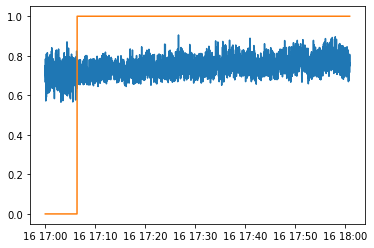

In [17]:
plt.plot(read)

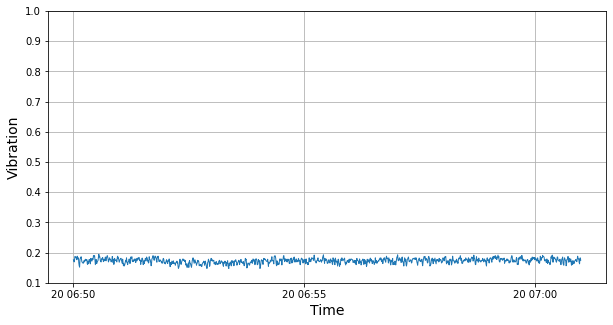

In [93]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(normal['Value'], 'C0', linewidth=1)
ax.set_xlabel('Time', size=14)
ax.set_ylabel('Vibration', size=14)
ax.set_ylim(top=1, bottom=0.1)
ax.grid()
fig.savefig('Image_Data/Normal_vibration.png', dpi=150)

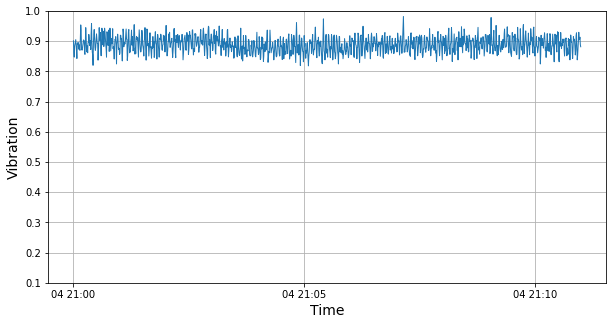

In [94]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(faulty['Value'], 'C0', linewidth=1)
ax.set_xlabel('Time', size=14)
ax.set_ylabel('Vibration', size=14)
ax.set_ylim(top=1, bottom=0.1)
ax.grid()
fig.savefig('Image_Data/Faulty_vibration.png', dpi=150)

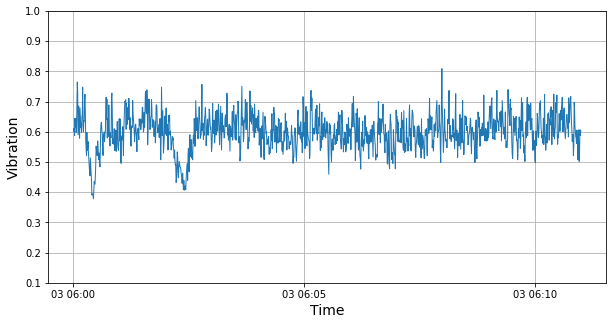

In [95]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(vfaulty['Value'], 'C0', linewidth=1)
ax.set_xlabel('Time', size=14)
ax.set_ylabel('Vibration', size=14)
ax.set_ylim(top=1, bottom=0.1)
ax.grid()
fig.savefig('Image_Data/VFaulty_vibration.png', dpi=150)

## FFT

In [7]:
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq

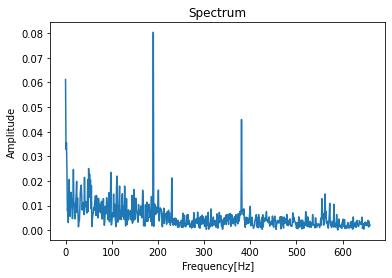

In [8]:
signal = np.array(normal['Value'])

fft_sig = rfft(signal, axis=-1, norm='ortho', overwrite_x=False,)

plt.plot(np.abs(fft_sig[1:]))
plt.title('Spectrum')
plt.xlabel('Frequency[Hz]')
plt.ylabel('Amplitude')
plt.show()

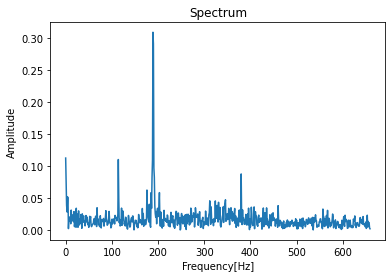

In [9]:
signal = np.array(faulty['Value'])

fft_sig = rfft(signal, axis=-1, norm='ortho', overwrite_x=False,)

plt.plot(np.abs(fft_sig[1:]))
plt.title('Spectrum')
plt.xlabel('Frequency[Hz]')
plt.ylabel('Amplitude')
plt.show()

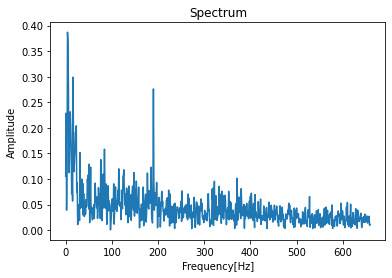

In [10]:
signal = np.array(vfaulty['Value'])

fft_sig = rfft(signal, axis=-1, norm='ortho', overwrite_x=False,)

plt.plot(np.abs(fft_sig[1:]))
plt.title('Spectrum')
plt.xlabel('Frequency[Hz]')
plt.ylabel('Amplitude')
plt.show()

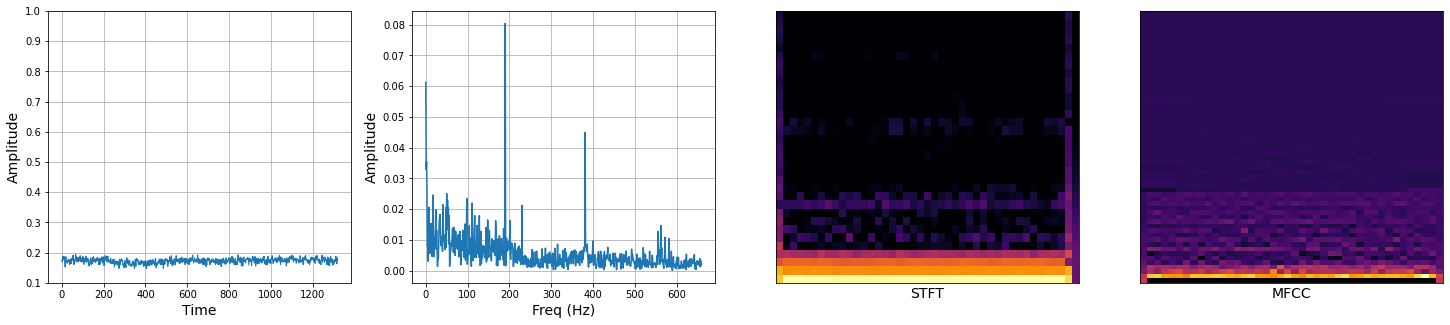

In [17]:
# Params
sample_rate = 2
frame_size = 256
hop = 32
n_coeff = 20
lifter = 0
n_mels = 20
dct = 1
win_length=32
wind = 'tukey'

signal = np.array(normal['Value'])

coef = librosa.feature.mfcc(y=np.array(signal), sr=sample_rate, lifter=lifter, n_fft=frame_size, hop_length=hop, win_length=win_length, n_mfcc=n_coeff, n_mels=n_mels, dct_type=dct, window=wind)
# Compute delta coefficients
deltas = librosa.feature.delta(coef)
deltasdeltas = librosa.feature.delta(deltas)

# Concatenate the MFCC and delta coefficients
features = np.concatenate((coef, deltas, deltasdeltas), axis=0)

fig, ax = plt.subplots(ncols=4, figsize=(25,5))

ax[0].plot(signal, 'C0', linewidth=1)
ax[0].set_xlabel('Time', size=14)
ax[0].set_ylabel('Amplitude', size=14)
ax[0].set_ylim(top=1, bottom=0.1)
ax[0].grid()

librosa.display.specshow(features, cmap='inferno', vmin=-10, ax=ax[3])
ax[3].set_xlabel('MFCC', size=14)

# STFT

#The length of each segment of the signal, measured in samples.
nperseg = 64
noverlap = 32

# Compute STFT
f, t, Zxx = stft(signal, fs=sample_rate, window=wind, nperseg=nperseg, noverlap=noverlap)
stft_coef = 20 * np.log10(np.abs(Zxx + np.finfo(float).eps))
ax[2].pcolormesh(t, f, stft_coef, cmap='inferno', vmin=-60)
ax[2].set_xlabel('STFT', size=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

fft_sig = rfft(signal, axis=-1, norm='ortho', overwrite_x=False,)

ax[1].plot(np.abs(fft_sig[1:]))
ax[1].set_xlabel('Freq (Hz)', size=14)
ax[1].set_ylabel('Amplitude', size=14)
ax[1].grid()
plt.show()
fig.savefig('Normal_sample.png', dpi=150)

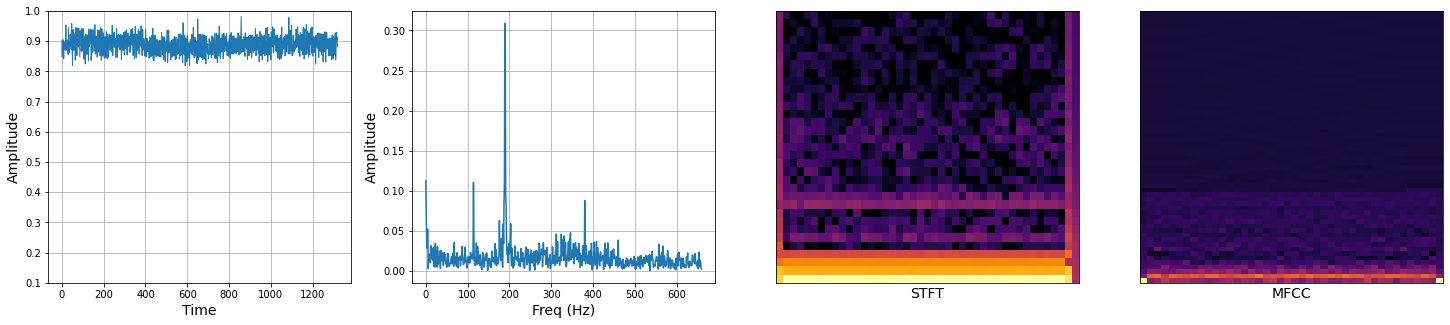

In [18]:
signal = np.array(faulty['Value'])

coef = librosa.feature.mfcc(y=np.array(signal), sr=sample_rate, lifter=lifter, n_fft=frame_size, hop_length=hop, win_length=win_length, n_mfcc=n_coeff, n_mels=n_mels, dct_type=dct, window=wind)
# Compute delta coefficients
deltas = librosa.feature.delta(coef)
deltasdeltas = librosa.feature.delta(deltas)

# Concatenate the MFCC and delta coefficients
features = np.concatenate((coef, deltas, deltasdeltas), axis=0)

fig, ax = plt.subplots(ncols=4, figsize=(25,5))

ax[0].plot(signal, 'C0', linewidth=1)
ax[0].set_xlabel('Time', size=14)
ax[0].set_ylabel('Amplitude', size=14)
ax[0].set_ylim(top=1, bottom=0.1)
ax[0].grid()

librosa.display.specshow(features, cmap='inferno', vmin=-10, ax=ax[3])
ax[3].set_xlabel('MFCC', size=14)

# STFT

#The length of each segment of the signal, measured in samples.
nperseg = 64
noverlap = 32

# Compute STFT
f, t, Zxx = stft(signal, fs=sample_rate, window=wind, nperseg=nperseg, noverlap=noverlap)
stft_coef = 20 * np.log10(np.abs(Zxx + np.finfo(float).eps))
ax[2].pcolormesh(t, f, stft_coef, cmap='inferno', vmin=-60)
ax[2].set_xlabel('STFT', size=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

fft_sig = rfft(signal, axis=-1, norm='ortho', overwrite_x=False,)

ax[1].plot(np.abs(fft_sig[1:]))
ax[1].set_xlabel('Freq (Hz)', size=14)
ax[1].set_ylabel('Amplitude', size=14)
ax[1].grid()
plt.show()
fig.savefig('Faulty_sample.png', dpi=150)

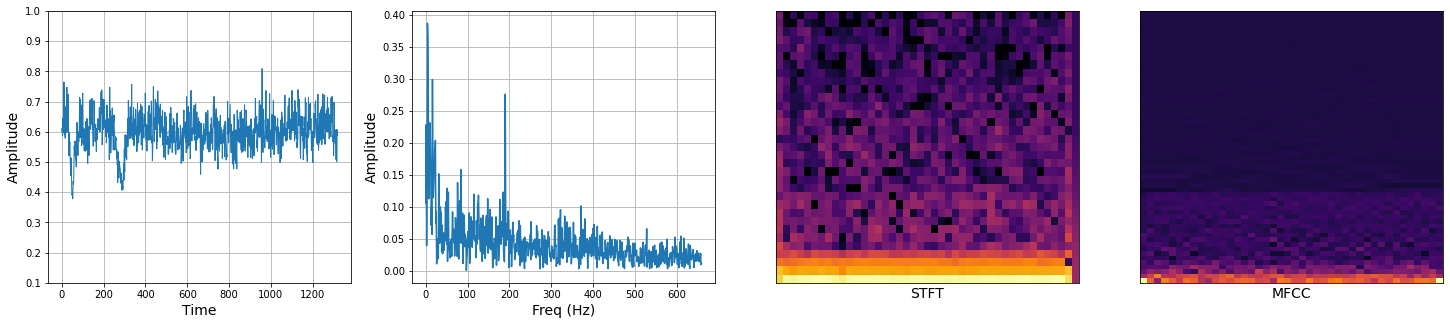

In [19]:
signal = np.array(vfaulty['Value'])

coef = librosa.feature.mfcc(y=np.array(signal), sr=sample_rate, lifter=lifter, n_fft=frame_size, hop_length=hop, win_length=win_length, n_mfcc=n_coeff, n_mels=n_mels, dct_type=dct, window=wind)
# Compute delta coefficients
deltas = librosa.feature.delta(coef)
deltasdeltas = librosa.feature.delta(deltas)

# Concatenate the MFCC and delta coefficients
features = np.concatenate((coef, deltas, deltasdeltas), axis=0)

fig, ax = plt.subplots(ncols=4, figsize=(25,5))

ax[0].plot(signal, 'C0', linewidth=1)
ax[0].set_xlabel('Time', size=14)
ax[0].set_ylabel('Amplitude', size=14)
ax[0].set_ylim(top=1, bottom=0.1)
ax[0].grid()

librosa.display.specshow(features, cmap='inferno', vmin=-10, ax=ax[3])
ax[3].set_xlabel('MFCC', size=14)

# STFT

#The length of each segment of the signal, measured in samples.
nperseg = 64
noverlap = 32

# Compute STFT
f, t, Zxx = stft(signal, fs=sample_rate, window=wind, nperseg=nperseg, noverlap=noverlap)
stft_coef = 20 * np.log10(np.abs(Zxx + np.finfo(float).eps))
ax[2].pcolormesh(t, f, stft_coef, cmap='inferno', vmin=-60)
ax[2].set_xlabel('STFT', size=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

fft_sig = rfft(signal, axis=-1, norm='ortho', overwrite_x=False,)

ax[1].plot(np.abs(fft_sig[1:]))
ax[1].set_xlabel('Freq (Hz)', size=14)
ax[1].set_ylabel('Amplitude', size=14)
ax[1].grid()
plt.show()
fig.savefig('VFaulty_sample.png', dpi=150)